## Домашняя работа 4. 

#### Выполнила Нателочка Зурабовна Кордзахия БЭК181 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, learning_curve

%matplotlib inline


In [20]:
df = pd.read_csv('data.adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [21]:
df = df.replace('?', np.nan)

In [22]:
df.isnull().sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [23]:
df.shape

(16280, 14)

In [24]:
df.dropna(inplace = True)
df.shape

(15347, 14)

In [25]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

Гууууууд. Хочу индексы почистить потому что я чистюля

In [26]:
df.reset_index(inplace = True)
df.drop(['index'],inplace = True, axis = 1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [29]:
cat_columns = [c for c in df.columns if df[c].dtype.name == 'object']
num_columns = [c for c in df.columns if df[c].dtype.name != 'object']

print('categorical_columns:', cat_columns)
print('numerical_columns:', num_columns)

categorical_columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', '>50K,<=50K']
numerical_columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [32]:
y = df['>50K,<=50K'].map(lambda x: 0 if x == '<=50K' else 1)
X = df.drop('>50K,<=50K', axis=1)
X_num = X[num_columns]

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**(1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std].

In [87]:
def plot_params_score(optimizer, title):
    res = optimizer.cv_results_
    param_name = list(res['params'][0].keys())[0]
    params = list(map(lambda x: x[param_name], res['params']))

    means = np.zeros(len(params))
    stds = np.zeros(len(params))
    for i, param in enumerate(params):
        scores = []
        for split_number in range(5):
            scores.append(res[f'split{split_number}_test_score'][i])
        means[i] = np.mean(scores)
        stds[i] = np.std(scores)

    plt.figure(figsize=(10, 7))
    plt.errorbar(range(len(params)), means, xerr=0.5, yerr=2*stds, linestyle='', fmt='o')
    plt.xticks(range(len(params)), params, rotation='vertical')
    plt.title(title, fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('roc_auc')
    plt.show()

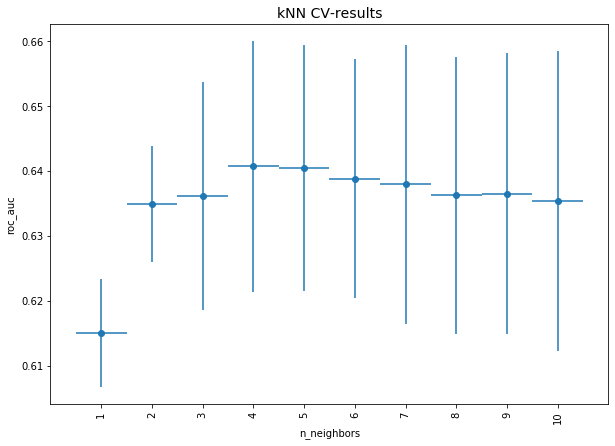

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                      weights='uniform'), 0.6407160528708574)

In [88]:
grid = {'n_neighbors': list(range(1, 11))}
optimizer = GridSearchCV(KNeighborsClassifier(), grid, cv=5, return_train_score=True, scoring='roc_auc')
optimizer.fit(X_num, y)
plot_params_score(optimizer, title = 'kNN CV-results')
optimizer.best_estimator_, optimizer.best_score_

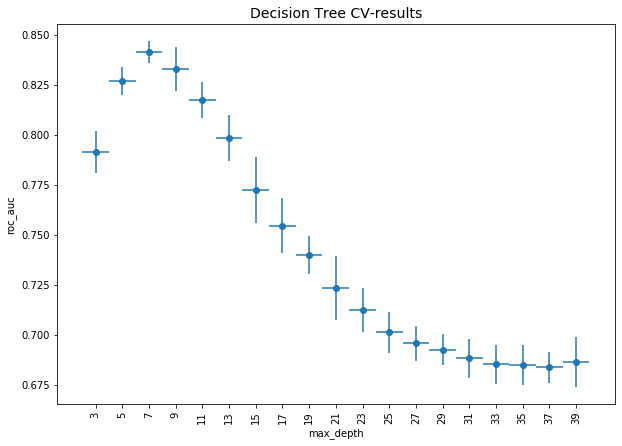

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'), 0.8414346274576933)

In [89]:
grid = {'max_depth': list(range(3, 40, 2))}
optimizer = GridSearchCV(DecisionTreeClassifier(random_state=42), grid, cv=5, return_train_score=True, scoring='roc_auc')
optimizer.fit(X_num, y)
optimizer.best_estimator_
plot_params_score(optimizer, title = 'Decision Tree CV-results')
optimizer.best_estimator_, optimizer.best_score_

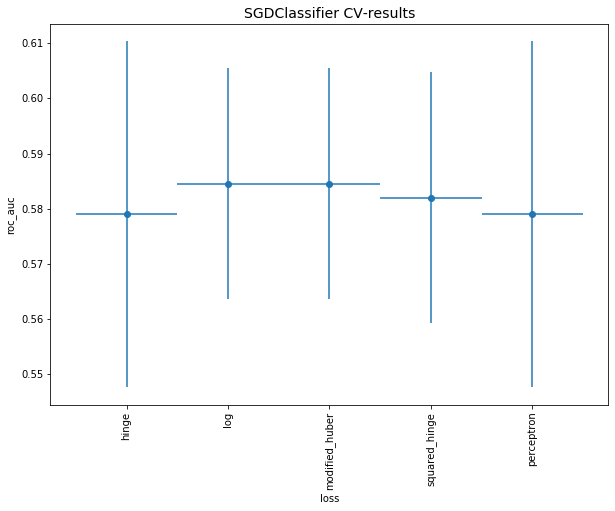

(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5,
               n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
               random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
               verbose=0, warm_start=False), 0.5845279280987187)

In [90]:
grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}
optimizer = GridSearchCV(SGDClassifier(random_state=42, max_iter=5, tol=None), grid, cv=5,
                         return_train_score=True, scoring='roc_auc')
optimizer.fit(X_num, y)
plot_params_score(optimizer, title='SGDClassifier CV-results')
optimizer.best_estimator_, optimizer.best_score_

Что вы можете сказать о получившихся графиках?

Decision Tree покакзал себя лучше всего. Наибольшее среднее значение качества получилось у дерева решений с max_depth=7, наибольший доверительный интервал - у SGDClassifier'а с loss='squared_hinge'

* С ростом k в алгоритме "ближайших соседей" после оптимального k=4 качество модели постепенно снижается.

* Если говорить про Decision Tree, то качество модели логично убывает при слишком больших значениях max_depth, так как вместе с тем растет и степень переобучения модели

* Модель с loss вида 'log' показывает не только наиболее высокие результаты по среднему значению ROC-AUC на кросс-валидации, но и имеет меньшую дисперсию этой метрики, т.е. обладает более стабильным качеством

**(0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [58]:
from sklearn.metrics import mean_squared_error as mse

def get_scores_list(X, y, clf, score, print_train=True):
    predictions = list()
    scores = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = np.mean(predictions, axis=0)
        scores.append(score(y, rf_prediction))
    if print_train:
        print('Last score', scores[-1])
    return scores

def plot_score_graph(clf, X_train, X_test, y_train, y_test, score, print_train=True):
    clf.fit(X_train, y_train)
    train_mses = get_scores_list(X_train, y_train, clf, score, False)
    test_mses = get_scores_list(X_test, y_test, clf, score)
    if print_train:
        plt.plot(train_mses, label='train set score')
    plt.plot(test_mses, label='test set score')
    plt.xlabel('n_estimators')
    plt.ylabel('score')
    plt.legend()

Last score 0.8161539417332335


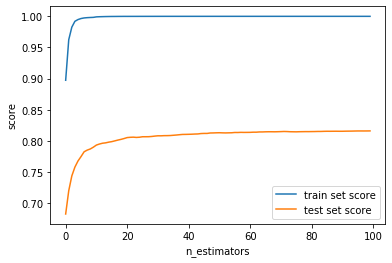

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.8, random_state=1543)
plot_score_graph(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
                 X_train, X_test, y_train, y_test, roc_auc_score)

**(0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [136]:
!pip install catboost

     |████████████████████████████████| 12.8 MB 2.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.8, random_state=1543)


100%|██████████| 26/26 [00:05<00:00,  4.39it/s]


Text(0, 0.5, 'error')

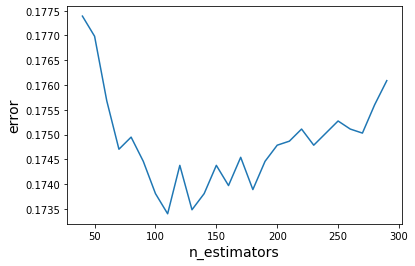

In [144]:
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score

n_estimators = np.arange(40, 300, 10)

error_scores = []
auc_scores = []
for n in tqdm(n_estimators):
    gradboost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=n)
    gradboost.fit(X_train, y_train)
    y_predicted = gradboost.predict(X_test)
    error_scores.append(1 - accuracy_score(y_test, y_predicted))

plt.plot(n_estimators, error_scores)
plt.xlabel('n_estimators', fontsize=14)
plt.ylabel('error', fontsize=14)

In [145]:
n_best = n_estimators[np.array(error_scores).argmin()]

print(f'Оптимальное количество деревьев: {n_best}')
print(f'Значение accuracy: {1 - np.array(error_scores).min()}')
print(f'Доля класса 0: {1 - y.mean()}')

Оптимальное количество деревьев: 110
Значение accuracy: 0.8266004235217462
Доля класса 0: 0.7432723007753959


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Text(0.5, 1.0, 'Capital gain')

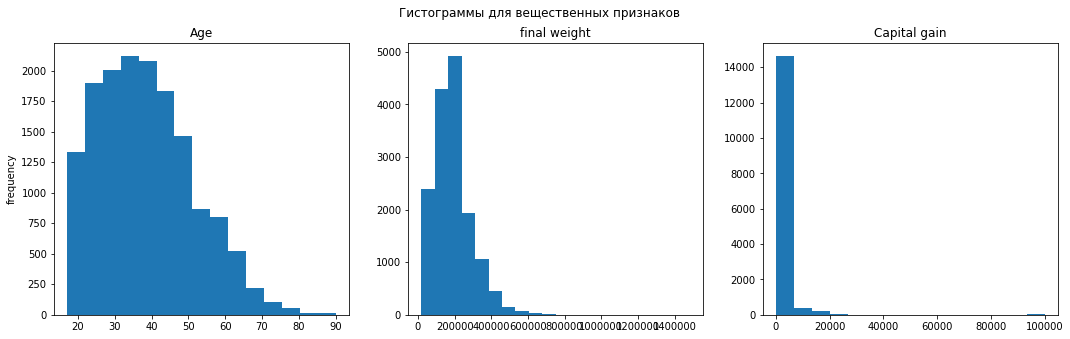

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

fig.suptitle('Гистограммы для вещественных признаков')
ax1.hist(X_num.age, bins=15)
ax1.set_title('Age')
ax1.set_ylabel('frequency')
ax2.hist(X_num.fnlwgt, bins=20)
ax2.set_title('final weight')
ax3.hist(X_num['capital-gain'], bins=15)
ax3.set_title('Capital gain')


Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [116]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_num_sc = sc.fit_transform(X_num)

In [117]:
X_num_sc

array([[-0.3429185 ,  0.90025802, -0.45078777, -0.06559951, -0.21874041,
         1.58822305],
       [ 0.11476013,  0.01068271, -0.05908582, -0.15043862, -0.21874041,
        -0.07417817],
       [-0.19035896, -0.10628026,  1.11602004, -0.15043862, -0.21874041,
        -0.07417817],
       ...,
       [-0.8768769 , -0.79685293,  1.11602004, -0.15043862, -0.21874041,
        -0.07417817],
       [ 1.56407578,  0.74838115, -0.45078777, -0.15043862, -0.21874041,
        -0.07417817],
       [-0.41919828, -1.22374144,  1.11602004, -0.15043862,  4.47344431,
         0.34142214]])

Text(0.5, 1.0, 'Capital gain')

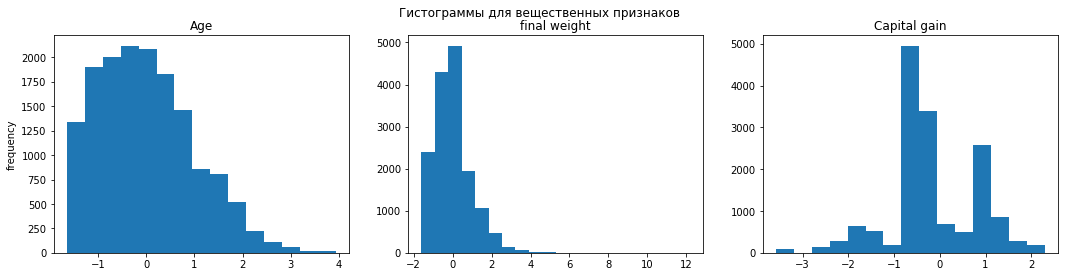

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

fig.suptitle('Гистограммы для вещественных признаков')
ax1.hist(X_num_sc[:, 0], bins=15)
ax1.set_title('Age')
ax1.set_ylabel('frequency')
ax2.hist(X_num_sc[:, 1], bins=20)
ax2.set_title('final weight')
ax3.hist(X_num_sc[:, 2], bins=15)
ax3.set_title('Capital gain')

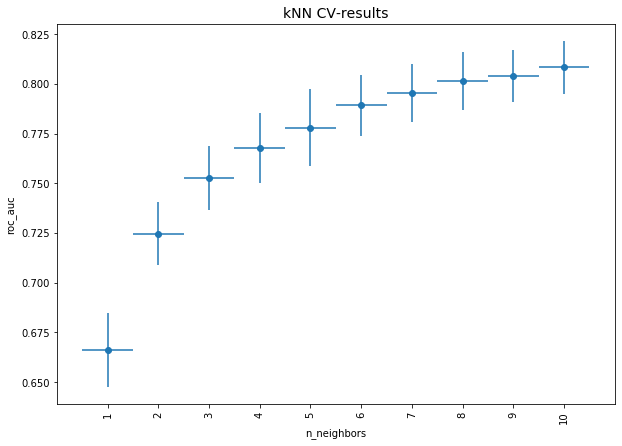

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                      weights='uniform'), 0.8083185448744348)

In [121]:
grid = {'n_neighbors': list(range(1, 11))}
optimizer = GridSearchCV(KNeighborsClassifier(), grid, cv=5, return_train_score=True, scoring='roc_auc')
optimizer.fit(X_num_sc, y)
plot_params_score(optimizer, title='kNN CV-results')
optimizer.best_estimator_, optimizer.best_score_

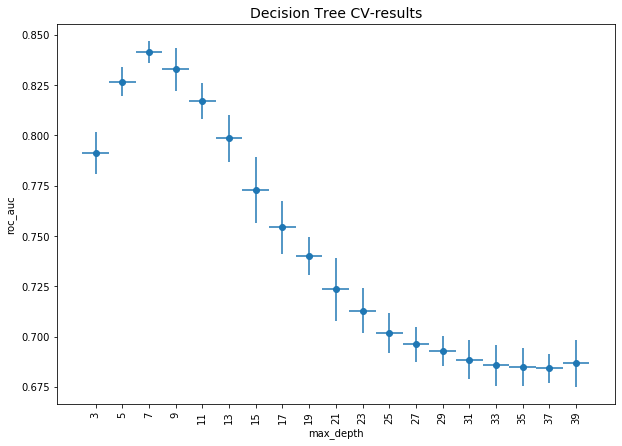

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'), 0.8414035871444119)

In [122]:
grid = {'max_depth': list(range(3, 40, 2))}
optimizer = GridSearchCV(DecisionTreeClassifier(random_state=42), grid, cv=5, return_train_score=True, scoring='roc_auc')
optimizer.fit(X_num_sc, y)
optimizer.best_estimator_
plot_params_score(optimizer, title='Decision Tree CV-results')
optimizer.best_estimator_, optimizer.best_score_


100%|██████████| 26/26 [00:05<00:00,  4.40it/s]


Text(0, 0.5, 'error')

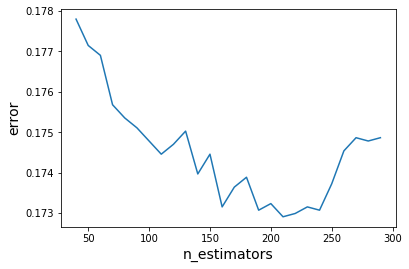

In [155]:
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score

n_estimators = np.arange(40, 300, 10)

sc2 = StandardScaler()
X_num_train_sc = sc2.fit_transform(X_train)
X_num_test_sc = sc2.transform(X_test)

error_scores = []

for n in tqdm(n_estimators):
    gradboost = GradientBoostingClassifier(learning_rate=0.099, n_estimators=n)
    gradboost.fit(X_num_train_sc, y_train)
    y_predicted = gradboost.predict(X_num_test_sc)
    error_scores.append(1 - accuracy_score(y_test, y_predicted))

plt.plot(n_estimators, error_scores)
plt.xlabel('n_estimators', fontsize=14)
plt.ylabel('error', fontsize=14)

In [156]:
# лучшее количество деревьев

n_best = n_estimators[np.array(error_scores).argmin()]

print(f'Оптимальное количество деревьев: {n_best}')
print(f'Значение accuracy: {1 - np.array(error_scores).min()}')
print(f'Доля класса 0: {1 - y.mean()}')

Оптимальное количество деревьев: 210
Значение accuracy: 0.827089102459684
Доля класса 0: 0.7432723007753959


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_num_sc, y, test_size=0.8, random_state=1543)
plot_score_graph(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
                 X_train, X_test, y_train, y_test, roc_auc_score)

Изменилось ли качество у некоторых алгоритмов?

Изменилось только качество kNN модели от масштабирования, собственно так и думали хех

**(1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [157]:
knn_grid = {'n_neighbors': np.arange(20, 60, 3), 'metric': ['euclidean', 'manhattan', 'chebyshev']}

def setka(alg=KNeighborsClassifier(), grid=knn_grid, X=X_num_sc, y=y):
        cv = GridSearchCV(alg,
                      grid,
                      scoring='roc_auc',
                      cv=KFold()
                     )
        cv.fit(X, y)

        return cv.best_params_, cv.best_score_, cv.cv_results_


kNN_best = setka()
kNN_best[1]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


0.8326078731190306

In [158]:
tree_grid = {'max_depth': np.arange(2, 35), 'criterion': ['gini', 'entropy']}
tree_best = setka(alg=DecisionTreeClassifier(), grid=tree_grid)
print(tree_best[:2])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


({'criterion': 'gini', 'max_depth': 7}, 0.8379622988010984)


In [159]:
RF_grid = {'criterion': ['gini', 'entropy'], 'max_features': [2, 3, 4, 5]}
RF_best = setka(RandomForestClassifier(n_estimators=80), RF_grid)
print(RF_best[:2])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


({'criterion': 'entropy', 'max_features': 4}, 0.8170012651928139)


In [162]:
GB_grid = {'criterion': ['friedman_mse'], 'max_features': [2, 3, 4, 5]}
GB_best = setka(alg=GradientBoostingClassifier(n_estimators=175), grid=GB_grid)
print(GB_best[:2])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


({'criterion': 'friedman_mse', 'max_features': 5}, 0.8643962881067294)


In [163]:
SGD_grid = {'loss': ['log', 'hinge', 'modified_huber'], 'penalty': ['l2', 'l1', 'elasticnet']}
SGD_best = setka(SGDClassifier(), SGD_grid)
print(SGD_best[0:2])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


({'loss': 'log', 'penalty': 'l2'}, 0.8203663509124997)


Какой из алгоритмов имеет наилучшее качество? 

Градиентный бустинг


**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Время сравнивать - дело неблагодарное, у разный моделей разный набор параметров и по сетке их проверка может по-разному времени занимать. Но давайте посмотрим.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


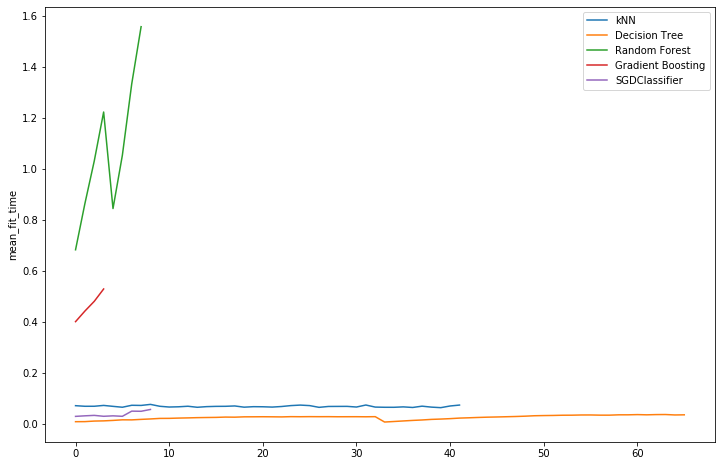

In [169]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(kNN_best[2]['mean_fit_time'], label='kNN')
ax.plot(tree_best[2]['mean_fit_time'], label='Decision Tree')
ax.plot(RF_best[2]['mean_fit_time'], label='Random Forest')
ax.plot(GB_best[2]['mean_fit_time'], label='Gradient Boosting')
ax.plot(SGD_best[2]['mean_fit_time'], label='SGDClassifier')
ax.set_ylabel('mean_fit_time')
ax.legend()

fig.show()

Рассмотрим отдельно в масштабе, но даже тут видно, что случайный лес - самый длинный, что логично.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


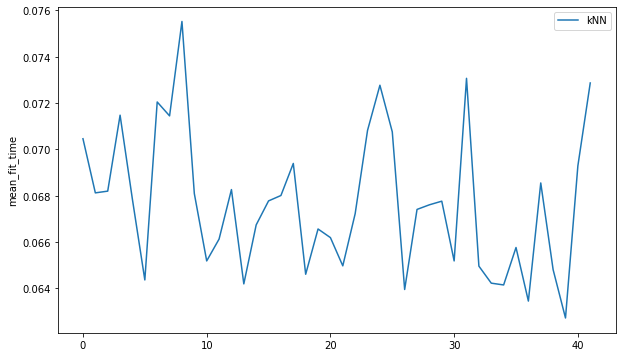

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(kNN_best[2]['mean_fit_time'], label='kNN')
ax.set_ylabel('mean_fit_time')

ax.legend()

fig.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


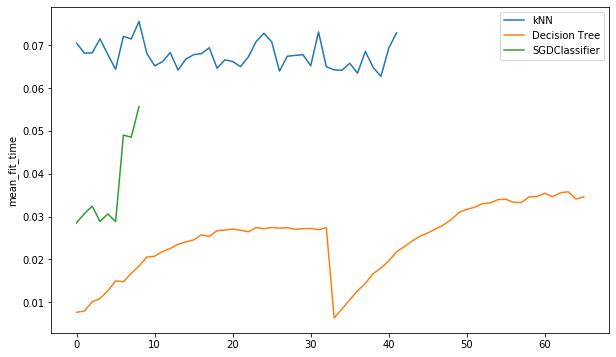

In [172]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_ylabel('mean_fit_time')
ax.plot(kNN_best[2]['mean_fit_time'], label='kNN')
ax.plot(tree_best[2]['mean_fit_time'], label='Decision Tree')
ax.plot(SGD_best[2]['mean_fit_time'], label='SGDClassifier')
ax.legend()

fig.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


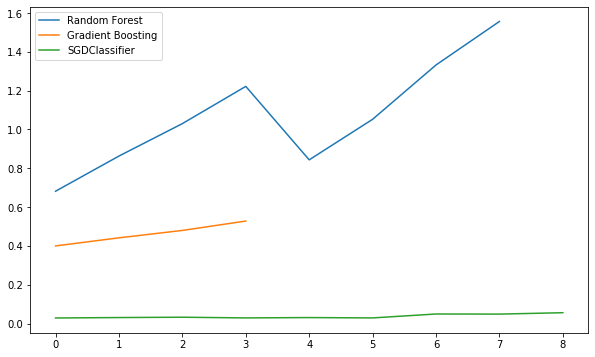

In [173]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(RF_best[2]['mean_fit_time'], label='Random Forest')
ax.plot(GB_best[2]['mean_fit_time'], label='Gradient Boosting')
ax.plot(SGD_best[2]['mean_fit_time'], label='SGDClassifier')
ax.legend()
fig.show()


Что и следовало доказать

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [176]:
ohe = pd.get_dummies(df.loc[:, df.columns[df.dtypes == 'object']].iloc[:, :-1], drop_first=True)
ohe.head()

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

Как же много всего надо делать как же грустно(((

In [188]:
df1 = pd.DataFrame(data=X_num_sc, columns={0: 'age', 1:'fnlwgt', 2:'education-num', 3:'capital-gain', 4:'capital-loss',
       5:'hours-per-week'})

In [189]:
X_new = pd.concat([ohe, df1], axis=1)

X_new.head()

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,race_Black,race_Other,race_White,sex_Male,0,1,2,3,4,5
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,-0.342919,0.900258,-0.450788,-0.065600,-0.21874,1.588223
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0.114760,0.010683,-0.059086,-0.150439,-0.21874,-0.074178
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,-0.190359,-0.106280,1.116020,-0.150439,-0.21874,-0.074178
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,-1.258276,-0.041382,-0.059086,-0.150439,-0.21874,-0.905379
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0.648719,-0.371197,1.116020,1.995391,-0.21874,-0.074178


In [196]:
clf = KNeighborsClassifier(n_neighbors = 10, metric =  'minkowski')
print("KNN:",cross_val_score(clf, X_new, y,cv = 5).mean())


clf = DecisionTreeClassifier(max_depth = 7,criterion = 'gini',random_state=42)
print("decisionTree",cross_val_score(clf, X_new, y,cv = 5).mean())


clf = SGDClassifier(loss = 'log',penalty = 'l2')
print("SGD",cross_val_score(clf, X_new, y,cv = 5).mean())


clf = RandomForestClassifier(n_estimators = 80,max_features =  0.9, criterion = 'entropy', n_jobs=4, random_state=7)
print("RF",cross_val_score(clf, X_new, y,cv = 5).mean())

KNN: 0.8296083669520676
decisionTree 0.844008711683399
SGD 0.8396430841991418
RF 0.8457679028384083


Ну вообще кажется чуть лучше стало но не то чтобы прям совсем где то лучше где то хуже, вот если бы было 90... другое дело совсем...

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Неа

## Поиск новых полезных признаков

**(1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [198]:
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)


#X2 = pd.concat([pd.DataFrame(poly.fit_transform(X_r_sc)), ohe.reset_index(drop=True)], axis=1)
#X2.head()
X_poly = pd.DataFrame(poly.fit_transform(X_num_sc))

In [202]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
res = []
for algas in tqdm(algs):
    alg_res = []
    for k in np.arange(6, 27, 3):
        trans_data = SelectKBest(score_func=mutual_info_classif, k=k).fit_transform(X_poly, y)
        alg_res.append(cross_val_score(alg, X=trans_data, y=y, scoring='roc_auc').mean())
    res.append(np.array(alg_res))


  0%|          | 0/5 [00:03<?, ?it/s]


TypeError: estimator should be an estimator implementing 'fit' method, {'mean_fit_time': array([0.07046286, 0.06812604, 0.06820114, 0.07147996, 0.06783334,
       0.06436698, 0.07204994, 0.07144992, 0.07552608, 0.068096  ,
       0.06518793, 0.06613064, 0.06826822, 0.06419706, 0.06674369,
       0.06777962, 0.06801271, 0.06939658, 0.06461255, 0.06656679,
       0.06619461, 0.06497542, 0.06722736, 0.07082335, 0.07277298,
       0.07075906, 0.06395483, 0.06741134, 0.0676109 , 0.06776722,
       0.06518825, 0.073071  , 0.06496366, 0.06422798, 0.06415081,
       0.06576761, 0.06345463, 0.06855416, 0.0648102 , 0.06272499,
       0.06929247, 0.07287073]), 'std_fit_time': array([0.00727096, 0.00329457, 0.00215081, 0.00329287, 0.00750171,
       0.00278194, 0.00832492, 0.01073203, 0.00305845, 0.00339673,
       0.00205501, 0.00020644, 0.00274908, 0.00228731, 0.00230093,
       0.00235545, 0.00145634, 0.00409054, 0.0028337 , 0.00138602,
       0.00133033, 0.00256931, 0.00023857, 0.00709701, 0.00935974,
       0.007302  , 0.00074231, 0.00112566, 0.0020504 , 0.00116711,
       0.00093727, 0.01205208, 0.00206108, 0.00046383, 0.00118433,
       0.00359983, 0.00152665, 0.00347239, 0.00238477, 0.00058005,
       0.00105832, 0.00119093]), 'mean_score_time': array([0.18991677, 0.20414527, 0.21494492, 0.23327708, 0.22529912,
       0.22736287, 0.24412831, 0.26828241, 0.28181664, 0.27204593,
       0.27427379, 0.28327854, 0.2918117 , 0.30598934, 0.25731111,
       0.27704167, 0.283638  , 0.27994506, 0.28858503, 0.29615458,
       0.31651489, 0.32253194, 0.34357254, 0.37482921, 0.37676334,
       0.36845271, 0.36483312, 0.39233772, 0.13970057, 0.15073021,
       0.15139699, 0.16639566, 0.19332139, 0.17859006, 0.17786423,
       0.18685651, 0.19087362, 0.19818465, 0.19959911, 0.21027891,
       0.22705825, 0.24211804]), 'std_score_time': array([0.00763849, 0.00142569, 0.00307545, 0.00194314, 0.00523493,
       0.00337228, 0.00762369, 0.01059372, 0.01274372, 0.00818724,
       0.00384239, 0.00194093, 0.00268115, 0.01157708, 0.01808024,
       0.01813826, 0.0103004 , 0.01049076, 0.00279207, 0.00432452,
       0.00607906, 0.01649993, 0.00934569, 0.02632171, 0.01033166,
       0.00562976, 0.00159811, 0.00793384, 0.00568394, 0.0033382 ,
       0.00351505, 0.00120046, 0.04247149, 0.00900563, 0.00137318,
       0.0050233 , 0.00160505, 0.00055621, 0.00285845, 0.00366937,
       0.00490352, 0.00465579]), 'param_metric': masked_array(data=['euclidean', 'euclidean', 'euclidean', 'euclidean',
                   'euclidean', 'euclidean', 'euclidean', 'euclidean',
                   'euclidean', 'euclidean', 'euclidean', 'euclidean',
                   'euclidean', 'euclidean', 'manhattan', 'manhattan',
                   'manhattan', 'manhattan', 'manhattan', 'manhattan',
                   'manhattan', 'manhattan', 'manhattan', 'manhattan',
                   'manhattan', 'manhattan', 'manhattan', 'manhattan',
                   'chebyshev', 'chebyshev', 'chebyshev', 'chebyshev',
                   'chebyshev', 'chebyshev', 'chebyshev', 'chebyshev',
                   'chebyshev', 'chebyshev', 'chebyshev', 'chebyshev',
                   'chebyshev', 'chebyshev'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_neighbors': masked_array(data=[20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59,
                   20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59,
                   20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'metric': 'euclidean', 'n_neighbors': 20}, {'metric': 'euclidean', 'n_neighbors': 23}, {'metric': 'euclidean', 'n_neighbors': 26}, {'metric': 'euclidean', 'n_neighbors': 29}, {'metric': 'euclidean', 'n_neighbors': 32}, {'metric': 'euclidean', 'n_neighbors': 35}, {'metric': 'euclidean', 'n_neighbors': 38}, {'metric': 'euclidean', 'n_neighbors': 41}, {'metric': 'euclidean', 'n_neighbors': 44}, {'metric': 'euclidean', 'n_neighbors': 47}, {'metric': 'euclidean', 'n_neighbors': 50}, {'metric': 'euclidean', 'n_neighbors': 53}, {'metric': 'euclidean', 'n_neighbors': 56}, {'metric': 'euclidean', 'n_neighbors': 59}, {'metric': 'manhattan', 'n_neighbors': 20}, {'metric': 'manhattan', 'n_neighbors': 23}, {'metric': 'manhattan', 'n_neighbors': 26}, {'metric': 'manhattan', 'n_neighbors': 29}, {'metric': 'manhattan', 'n_neighbors': 32}, {'metric': 'manhattan', 'n_neighbors': 35}, {'metric': 'manhattan', 'n_neighbors': 38}, {'metric': 'manhattan', 'n_neighbors': 41}, {'metric': 'manhattan', 'n_neighbors': 44}, {'metric': 'manhattan', 'n_neighbors': 47}, {'metric': 'manhattan', 'n_neighbors': 50}, {'metric': 'manhattan', 'n_neighbors': 53}, {'metric': 'manhattan', 'n_neighbors': 56}, {'metric': 'manhattan', 'n_neighbors': 59}, {'metric': 'chebyshev', 'n_neighbors': 20}, {'metric': 'chebyshev', 'n_neighbors': 23}, {'metric': 'chebyshev', 'n_neighbors': 26}, {'metric': 'chebyshev', 'n_neighbors': 29}, {'metric': 'chebyshev', 'n_neighbors': 32}, {'metric': 'chebyshev', 'n_neighbors': 35}, {'metric': 'chebyshev', 'n_neighbors': 38}, {'metric': 'chebyshev', 'n_neighbors': 41}, {'metric': 'chebyshev', 'n_neighbors': 44}, {'metric': 'chebyshev', 'n_neighbors': 47}, {'metric': 'chebyshev', 'n_neighbors': 50}, {'metric': 'chebyshev', 'n_neighbors': 53}, {'metric': 'chebyshev', 'n_neighbors': 56}, {'metric': 'chebyshev', 'n_neighbors': 59}], 'split0_test_score': array([0.83074198, 0.83182759, 0.83368113, 0.83595907, 0.83691336,
       0.83621013, 0.83718751, 0.83748475, 0.83897239, 0.83845389,
       0.83808717, 0.83838787, 0.8378238 , 0.83737723, 0.83465454,
       0.83627188, 0.83652253, 0.83658865, 0.83712454, 0.8363206 ,
       0.83657217, 0.83620708, 0.83669811, 0.83622539, 0.83724122,
       0.83787558, 0.8384661 , 0.8380655 , 0.82870401, 0.82926574,
       0.829222  , 0.83052306, 0.83162251, 0.8321285 , 0.83411194,
       0.8345813 , 0.83694245, 0.83570934, 0.83650127, 0.83631206,
       0.8368331 , 0.83617463]), 'split1_test_score': array([0.82342356, 0.82565027, 0.82596754, 0.82812231, 0.82839465,
       0.82834675, 0.82830608, 0.82843918, 0.82848757, 0.82905847,
       0.82906283, 0.82830974, 0.8284844 , 0.82870845, 0.82688965,
       0.82808876, 0.82727283, 0.82857218, 0.82773874, 0.8283799 ,
       0.82853655, 0.82963343, 0.82953131, 0.82919959, 0.82959998,
       0.82918732, 0.82957633, 0.82959612, 0.81771285, 0.82227028,
       0.82469976, 0.82514825, 0.82627026, 0.82550886, 0.82692261,
       0.82767045, 0.82691489, 0.82765007, 0.82811261, 0.8271522 ,
       0.82695368, 0.82703938]), 'split2_test_score': array([0.82553971, 0.8278182 , 0.82952874, 0.82984259, 0.8306824 ,
       0.82956036, 0.82938218, 0.82865102, 0.82853919, 0.82847933,
       0.82889464, 0.82880545, 0.82929948, 0.82948863, 0.82567888,
       0.82731529, 0.82822473, 0.82842975, 0.83010217, 0.83016911,
       0.83087035, 0.83093839, 0.83003014, 0.82994993, 0.828911  ,
       0.8293338 , 0.82978064, 0.82968945, 0.82433447, 0.82544593,
       0.82695634, 0.82728846, 0.82845628, 0.8292468 , 0.82956615,
       0.83015205, 0.83032824, 0.82964925, 0.82890023, 0.82943745,
       0.83034081, 0.83008631]), 'mean_test_score': array([0.82656848, 0.82843206, 0.82972582, 0.83130808, 0.83199689,
       0.83137253, 0.8316254 , 0.83152517, 0.83199994, 0.83199746,
       0.83201508, 0.83183455, 0.8318694 , 0.83185826, 0.82907458,
       0.83055885, 0.83067352, 0.83119704, 0.83165525, 0.8316233 ,
       0.8319931 , 0.83225972, 0.83208665, 0.83179176, 0.8319176 ,
       0.83213241, 0.83260787, 0.83245054, 0.82358373, 0.82566066,
       0.82695937, 0.82765328, 0.82878304, 0.82896137, 0.83020027,
       0.83080131, 0.83139526, 0.83100297, 0.83117152, 0.83096734,
       0.83137593, 0.83110017]), 'std_test_score': array([0.00307509, 0.00255904, 0.00315224, 0.00336305, 0.0035999 ,
       0.00345656, 0.00395765, 0.00421515, 0.00493055, 0.00457173,
       0.00429437, 0.00463854, 0.00422373, 0.00391567, 0.00397666,
       0.00405224, 0.00415429, 0.00381308, 0.0039861 , 0.00340102,
       0.00337531, 0.00284172, 0.0032673 , 0.00315013, 0.00377505,
       0.00406167, 0.00414343, 0.00397075, 0.00451855, 0.00286001,
       0.00184626, 0.00220944, 0.0021973 , 0.00271007, 0.00296917,
       0.00285853, 0.0041628 , 0.00342668, 0.00378258, 0.00389292,
       0.00409925, 0.00379784]), 'rank_test_score': array([40, 37, 33, 23,  9, 22, 17, 19,  7,  8,  6, 14, 12, 13, 34, 31, 30,
       24, 16, 18, 10,  3,  5, 15, 11,  4,  1,  2, 42, 41, 39, 38, 36, 35,
       32, 29, 20, 27, 25, 28, 21, 26], dtype=int32)} was passed

Честно говоря я устала.........

Работа классная (конечно, она же ШАДовская), но кажется нам немного сложновато такое делать. Но скиллы прокачиваются огого!!!

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [ ]:
#your code here

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберете тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [ ]:
#your code here